In [ ]:
"""
Use all variables (continuous, categorical) as features
Use X_adasyn and y_adasyn as train data (imbalanced classes handled)

Refine models:

1. Logistic Regression
    - Grid search CV: solver, penalty, C
    - Adjust threshold: compared to baseline model with 0.41 precision, recall has improved from 61% to 82%!
    
2. kNN
    - Feature engineering
    - Tune hyperparameters (grid search)
    
3. Naive Bayes
    - Higher recall but lower precision.


Conclusion:
ROC AUC highest - Logistic regression
Recall highest - Naive Bayes (65%)

"""

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [45]:
# Load data
# All variables (continuous + categorical)
df_train = pd.read_pickle('../dump/df_train.csv')
df_test = pd.read_pickle('../dump/df_test.csv')


X_train = pd.read_pickle('../dump/X_adasyn')
y_train = pd.read_pickle('../dump/y_adasyn')
X_test = pd.read_pickle('../dump/X_test_processed')
y_test = df_test['target']

In [12]:
df_train.shape, X_train.shape

((19158, 14), (28836, 32))

In [15]:
Counter(y_train)

Counter({1: 14455, 0: 14381})

In [32]:
X_train.iloc[:,:4]

,city_development_index,training_hours,experience,last_new_job
14360,0.738919,-0.772050,0.530812,0.013022
4467,-2.025381,-0.755399,-0.731859,0.013022
18014,-1.660590,0.609973,-0.731859,-0.588135
18178,0.657855,1.642328,-0.984393,-0.588135
7086,0.657855,0.010542,1.793483,1.816493
...,...,...,...,...
18898,0.738919,-0.988511,0.530812,1.816493
11798,0.738919,0.909689,1.793483,1.215336
6637,0.738919,-0.289174,-0.479325,0.013022
2575,0.657855,0.143749,-0.858126,-0.588135


### 1. Logistic Regression

In [111]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
# print('intercept: ', round(lm.intercept_[0], 4))
# pd.DataFrame(list(zip(cat_variables,np.transpose(lm.coef_))),columns=['Feature','Coef'])\
# .sort_values('Coef',ascending=False)

LogisticRegression(C=100000, solver='newton-cg')

In [112]:
# Coefficient for top features

feature = X_train.columns
coef = pd.DataFrame(list(zip((feature),lm.coef_[0])),columns = ['Feature','Coefficient']).\
sort_values(['Coefficient'],ascending=False)
top_feature = coef.head(10)
top_feature

,Feature,Coefficient
31,company_type_unknown,0.851339
29,company_type_Public Sector,0.375862
18,major_discipline_unknown,0.344082
28,company_type_Other,0.202447
4,relevent_experience_No relevent experience,0.159225
3,last_new_job,0.119331
34,last_job_city,0.040805
32,training_hours_experience,0.003910
33,last_job_experience,0.000156
30,company_type_Pvt Ltd,-0.008773


In [113]:
bottom_feature = coef.tail(10)
bottom_feature

,Feature,Coefficient
24,company_size_5000-9999,-0.475402
25,company_size_<10,-0.496889
15,major_discipline_No Major,-0.501393
16,major_discipline_Other,-0.507041
23,company_size_500-999,-0.532150
0,city_development_index,-0.551382
7,enrolled_university_unknown,-0.606558
8,education_level_High School,-1.191722
12,education_level_unknown,-1.198249
11,education_level_Primary School,-1.821528


In [17]:
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1098,455
Changing (1),149,427


In [18]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.7162987317989666 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.88      0.71      0.78      1553
           1       0.48      0.74      0.59       576

    accuracy                           0.72      2129
   macro avg       0.68      0.72      0.69      2129
weighted avg       0.77      0.72      0.73      2129



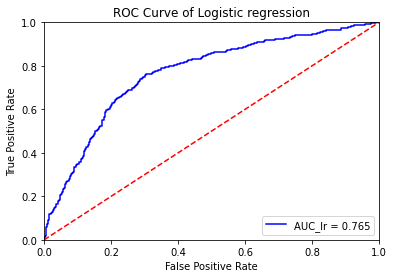

In [19]:
# Logistic regression ROC curve
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_lr = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic regression')
plt.show()

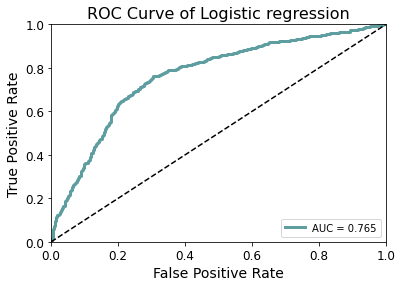

In [200]:
# Logistic regression ROC curve
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)


fig, ax = plt.subplots()

plt.plot(fpr, tpr, 'cadetblue', linewidth=3, label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.title('ROC Curve of Logistic regression',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

fig.savefig('../plot/ROC_lr_1.pdf', bbox_inches='tight', transparent=True)

#### Grid search cross-validation
Logistic regression does not really have hyperparameters to tune.
* **solver** : ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
* **penalty** (regularization) : ‘none’, ‘l1’, ‘l2’, ‘elasticnet’
* **C** (penalty strength) : 100, 10, 1.0, 0.1, 0.01

In [114]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [169]:
lm_2=LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100000000, 10000, 1000, 100, 1.0, 0.1, 0.01]

In [170]:
# Define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lm_2, param_grid=grid, n_jobs=-1, cv=5, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [171]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.674369 using {'C': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [172]:
lm_2 = grid_search.best_estimator_
# LogisticRegression(solver='lbfgs', C=10000, penalty='l2')
lm_2.fit(X_train,y_train)
y_predict = lm_2.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Predict-not changing (0),Predict-change (1)
Not changing (0),1097,456
Changing (1),145,431


In [173]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.7177078440582433 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.88      0.71      0.78      1553
           1       0.49      0.75      0.59       576

    accuracy                           0.72      2129
   macro avg       0.68      0.73      0.69      2129
weighted avg       0.78      0.72      0.73      2129



In [ ]:
# Precision and recall for (1) both improved 0.01...

#### Cross-validation

In [162]:
from sklearn.model_selection import cross_val_score

In [165]:
recalls = cross_val_score(lm_2, X_train, y_train, cv=5, scoring='recall')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [168]:
print('Mean:', np.mean(recalls))
print('All recalls:', (recalls))

Mean: 0.6751988931165687
All recalls: [0.76582497 0.71705292 0.63161536 0.61674161 0.6447596 ]


### * Adjust threshold

In [143]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Looking', 'Looking'],
           yticklabels=['Not Looking', 'Looking']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [144]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm_2, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [161]:
threshold = 0.4
y_predict = (lm.predict_proba(X_test)[:, 1] >= threshold)
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.90      0.56      0.69      1553
           1       0.41      0.82      0.55       576

    accuracy                           0.63      2129
   macro avg       0.65      0.69      0.62      2129
weighted avg       0.76      0.63      0.65      2129



In [ ]:
# Compared to baseline Logistic regression model with 0.41 precision, recall has improved from 0.61 to 0.82!

### * Feature Engineering

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

In [72]:
X_train['training_hours_experience'] = X_train['training_hours'] * X_train['experience']
X_test['training_hours_experience'] = X_test['training_hours'] * X_test['experience']

X_train['last_job_experience'] = X_train['experience'] / X_train['last_new_job']
X_test['last_job_experience'] = X_test['experience'] / X_test['last_new_job']

X_train['last_job_city'] = X_train['last_new_job'] * X_train['city_development_index']
X_test['last_job_city'] = X_test['last_new_job'] * X_test['city_development_index']

X_train['training_hours_city'] = X_train['training_hours'] * X_train['city_development_index']
X_test['training_hours_city'] = X_test['training_hours'] * X_test['city_development_index']

In [69]:
X_train['last_job_experience'] = scaler.fit_transform(X_train[['last_job_experience']])

In [70]:
X_train

,city_development_index,training_hours,experience,last_new_job,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment,enrolled_university_unknown,education_level_High School,education_level_Masters,...,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_unknown,training_hours_experience,last_job_experience,last_job_city,training_hours_city
0,0.738919,-0.488985,1.793483,-0.588135,0.00000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.876986,-0.116277,-0.434584,-0.361320
1,-0.428410,-0.305825,0.530812,1.816493,1.00000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,-0.162336,-0.004334,-0.778203,0.131018
2,-1.660590,0.293607,-0.731859,-1.189292,1.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.214879,0.006492,1.974927,-0.487560
3,-0.323026,-0.222571,-1.300061,-1.189292,1.00000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.289355,0.022496,0.384172,0.071896
4,-0.501368,-0.955209,1.793483,1.215336,0.00000,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,-1.713152,0.035312,-0.609331,0.478911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28831,0.316702,-0.564869,-0.473409,-0.588135,0.00000,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.267414,0.012842,-0.186264,-0.178895
28832,0.472487,-0.425288,0.459461,-0.588135,0.78254,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.195404,-0.040293,-0.277886,-0.200943
28833,0.770312,-0.283658,0.430281,1.337864,0.00000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.122053,-0.003349,1.030573,-0.218506
28834,0.738919,-0.152315,0.445527,1.410450,0.00000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.067860,-0.003541,1.042209,-0.112548


In [47]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1099,454
Changing (1),149,427


In [51]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1092,461
Changing (1),151,425


In [57]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1092,461
Changing (1),151,425


In [73]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1100,453
Changing (1),149,427


In [ ]:
# Interaction terms do not improve the model

### 2. KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train,y_train)
pred = knn_3.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (kNN, n=3):\n\n',classification_report(y_test,pred))

Accuracy score: 0.6594645373414749 

Classification report (kNN, n=3):

               precision    recall  f1-score   support

           0       0.82      0.68      0.74      1553
           1       0.41      0.60      0.49       576

    accuracy                           0.66      2129
   macro avg       0.62      0.64      0.62      2129
weighted avg       0.71      0.66      0.68      2129



In [21]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train,y_train)
pred = knn_5.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (kNN, n=5):\n\n',classification_report(y_test,pred))

Accuracy score: 0.6491310474401127 

Classification report (kNN, n=5):

               precision    recall  f1-score   support

           0       0.84      0.64      0.73      1553
           1       0.41      0.67      0.51       576

    accuracy                           0.65      2129
   macro avg       0.62      0.66      0.62      2129
weighted avg       0.72      0.65      0.67      2129



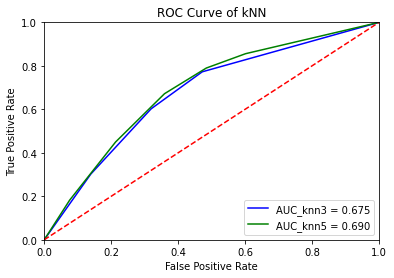

In [22]:
# knn (n=3)
y_scores = knn_3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_knn3 = %0.3f' % roc_auc)

# knn (n=5)
y_scores = knn_5.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'AUC_knn5 = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

### 3. Naive Bayes

In [156]:
nb = GaussianNB()
nb.fit(X_train,y_train)
pred = nb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Naive Bayes):\n\n',classification_report(y_test,pred))

Accuracy score: 0.538750587130108 

Classification report (Naive Bayes):

               precision    recall  f1-score   support

           0       0.84      0.45      0.59      1553
           1       0.34      0.77      0.48       576

    accuracy                           0.54      2129
   macro avg       0.59      0.61      0.53      2129
weighted avg       0.71      0.54      0.56      2129



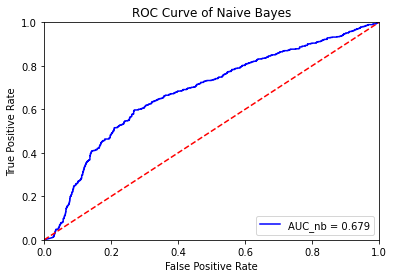

In [157]:
# Naive Bayes ROC curve
y_scores = nb.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_nb = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Naive Bayes')
plt.show()

In [158]:
# Compared to baseline version, Naive Bayes has higher recall but lower precision.